In [1]:
# Imports
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import random

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

In [2]:
# Class of k-Nearest Neigbor Classifier

class kNN():
    
    def __init__(self, k = 3, exp = 2, normalise=False):
        
        self.k = k
        self.exp = exp
        self.normalise = normalise
      
    
    def fit(self, X_train, Y_train):
    
        if self.normalise:
            self.X_train = normalise(X_train)
        else:
            self.X_train = X_train
        self.Y_train = Y_train
         

    def get_discrete_classification(self, X_test):
    
        if self.normalise:
            X_test = normalise(X_test)
            
        Y_pred_test = []

        for i in range(len(X_test)):
            # i-th test instance
            test_instance = X_test.iloc[i]  
            
            # list of distances of the i-th test_instance for all the train_instances in X_train
            distances = []  
          
            # iterate over all instances in X_train
            for j in range(len(self.X_train)):  
                train_instance = self.X_train.iloc[j]
                distance = self.Minkowski_distance(test_instance, train_instance)
                distances.append(distance)
        
            # Store distances in a dataframe. The dataframe has the index of 
            # Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the class with the highest count;
            # i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
        ''' Computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2) '''
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
        return distance
    
    
    #########
    # PART B
    #########
    # Add  to  class  kNN  method  normalize  that  normalizes  the  input  attributes  of  the training data
    # X_train and test data X_test. We note that attribute normalization is important since all the attributes 
    # receive equal weights when instance distances are being computed. To implement method normalize you might
    # use method max of pandas.DataFrame since both X_train and X_test are pandas.DataFrame. 
    def normalise(X) -> pd.DataFrame:
        ''' 
        NB:  this has been put INSIDE the class becuase that is what is specified in the lab spec. This 
        would probably provide more accurate results if the entire dataset was normalised outside of the
        class and then split into a train/test split. 
        '''
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
    
    #########
    # PART C
    #########
    # Computes for all the test instances in X_test the posterior class probabilities. This means that
    # the method computes for each row (instance) in X_test a row with probability of class 1, probability
    # of class 2, and probability of class N. Combine the rows of the posterior class probabilities in 
    # pandas.DataFrame object that will be the output of the method getClassProbs.
    def get_class_probs(self, X_test) -> pd.DataFrame:
        
        class_probs, columns = self.create_probs(X_test)
        
        for i in range(len(X_test)):
            test_instance = X_test.iloc[i]
            distances = []
    
            for j in range(len(self.X_train)):
                train_instance = self.X_train.iloc[j]
                distance = self.Minkowski_distance(test_instance, train_instance)  
                distances.append(distance)
            
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            row = self.set_probs(self.Y_train[df_knn.index].value_counts(), columns)
            class_probs.loc[i] = row
        
        return class_probs
            

    def create_probs(self, X_test):
        ''' Create a new dataframe that holds all of the values for the number of instances per column''' 
        class_columns = []
        classes = self.Y_train.value_counts()
        
        for index, value in classes.items():
            class_columns.append(index)
            class_probs = pd.DataFrame(columns=class_columns)
            
        return class_probs, class_columns
    

    def set_probs(self, classifications, columns):
        ''' Set the probabilities for each classification in the row ''' 
        row = [0]*len(columns)
        
        for classification, count in classifications.items():
            
            for column in columns:
                index = columns.index(classification)
                row[index] = count / self.k
                
        return row
    
    #########
    # PART D
    #########
    # Add to class kNN method getPrediction that computes for all the test instances in  X_test  regression
    # values  for  the  output  attribute.  This  means  that  the  method computes for each instance (row)
    # in X_test a regression value equal to the average of  y  values  in  Y_train  of  the  k-nearest  neighbors
    # of  the  instance  in  X_train. Combine  the  computed  regression  values  for  all  the  instances  in  
    # X_test  in pandas.DataFrame object that will be the output of the method getPrediction. 
    def get_predictions(self, X) -> pd.DataFrame:
        
        predictions = pd.DataFrame(columns = ['Reg Price'])
        class_probs = self.get_class_probs(X)
        
        #Iterate over all classProbabilities rows
        for i in class_probs.index:               
            row = class_probs.loc[i]
            cost = self.compute_cost(row)
            predictions.loc[i] = cost
                
        return predictions
    
    def compute_cost(self, row):
        regression_cost = 0
        
        #Iterate over each instance class Probability
        for price, probability in row.iteritems():
            #update regression price, by: price * probability
            regression_cost += price*probability
            
        return [regression_cost]


In [3]:
def k_experiment(csv_file_name, normalise=False):
    ##################################################
    # Hold-out testing: Training and Test set creation
    ##################################################

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

    trainAcc = np.zeros(len(k_range))
    testAcc = np.zeros(len(k_range))


    index = 0 
    for k  in  k_range:
        clf = kNN(k, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.get_discrete_classification(X_train)
        Y_predTest = clf.get_discrete_classification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1

    plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    
    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)

In [4]:
def exp_experiment(csv_file_name, normalise=False):

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    exp_range = [2,  100, 10000] 

    trainAcc = np.zeros(len(exp_range))
    testAcc = np.zeros(len(exp_range))

    index = 0 
    for exp  in  exp_range:
        clf = kNN(k = 3, exp = exp, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.get_discrete_classification(X_train)
        Y_predTest = clf.get_discrete_classification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1

    plt.plot(exp_range,trainAcc,'ro-',exp_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xscale('log')
    plt.xlabel('exp')
    plt.ylabel('Accuracy')

    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)


Test  the  kNN  classifier  on  the  diabetis  and  glass  classification  data  sets  (see Appendix A) for the case when the data is not normalized and the case when the data is normalized. Indicate whether the training and  hold-out accuracy rates improve with normalization.  

For  testing  the  kNN  classifier  you  might  use  the  script  provided  in  the  Jupiter notebook.  The  script  provides  a  plot  with  training  and  hold-out  accuracy  rates  in function of parameter k of the kNN classifier. 

Test the kNN classifier on the glass classification data sets the data is normalized for different  values  of  the  exp  parameter  of  the  Minkowski  distance.  Indicate  whether the training and  hold-out accuracy rates changes due to exp. For this task you might use the second testing script provided in the Jupiter note.

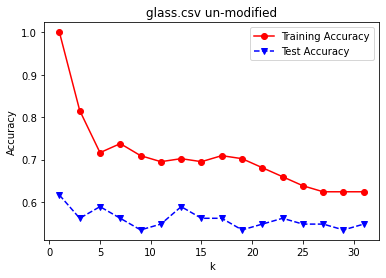

In [5]:
k_experiment('glass.csv', normalise=False)

In [6]:
k_experiment('glass.csv', normalise=True)

NameError: name 'normalise' is not defined

In [ ]:
exp_experiment('glass.csv', normalise=False)

In [ ]:
exp_experiment('glass.csv', normalise=True)

In [ ]:
data = pd.read_csv('glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

clf = kNN()
clf.fit(X_train, Y_train)
clf.get_class_probs(X_test)


In [ ]:
def regression(csv_file_name):

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

    trainAcc = np.zeros(len(k_range))
    testAcc = np.zeros(len(k_range))

    index = 0 
    for k  in  k_range:
        clf = kNN(k)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.get_predictions(X_train)
        Y_predTest = clf.get_predictions(X_test)
        trainAcc[index] = mean_absolute_error(Y_train, Y_predTrain)
        testAcc[index] = mean_absolute_error(Y_test, Y_predTest)
        index += 1

    plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')

In [ ]:
regression('autoprice.csv')